# Exploratory Data Analysis

### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from config.data_args import DataArgs
from statsmodels.stats.weightstats import DescrStatsW

# from src.preprocessing.preprocessor import LogPreprocessor
from src.preprocessing.preprocessor import LogRegPreprocessor

preprocessor = LogRegPreprocessor(model_type='eda')
args = DataArgs()


In [3]:
use_columns = ['title_en','description_en','research_fields_en','description_sv','title_sv','research_fields_sv' ,'funding_year'] 
data = pd.read_excel(args.raw_data_path, usecols = use_columns)

# Output first five rows
print(data.info())
print(f'{sum(data["research_fields_en"].str.count("Unclassified"))} research projects are unclassified.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59220 entries, 0 to 59219
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title_sv            58629 non-null  object 
 1   title_en            56813 non-null  object 
 2   funding_year        52387 non-null  float64
 3   research_fields_en  59220 non-null  object 
 4   research_fields_sv  59220 non-null  object 
 5   description_sv      46770 non-null  object 
 6   description_en      44825 non-null  object 
dtypes: float64(1), object(6)
memory usage: 3.2+ MB
None
9289 research projects are unclassified.


In [4]:
data = data.dropna(subset=['research_fields_en','title_en', 'description_en'])

data.rename(columns = {f'research_fields_en':'labels'}, inplace = True)
data["text"] = data[f'title_en'].astype(str) +"\n"+ data[f'description_en']

In [6]:
# CLEANING:
# Remove unclassified data

data = data[data['labels'] != 'Unclassified']

word_counts = data[['text']].apply(lambda x: len(' '.join(x).split()), axis=1)
data = data[word_counts >= args.min_words]


data.head(1)

print(f"{len(data)} research projects for EDA.")

41997 research projects for EDA.


## Map data to corresponding SCB class

In [7]:
# Load SCB classifications & Preprocess

df_classifications = pd.read_excel(args.raw_classifications_SCB,  index_col=0)
print(df_classifications)
df_classifications['Label_en'] = df_classifications['Label_en'].apply(lambda x: x.strip().lower())
df_classifications['Label_sv'] = df_classifications['Label_sv'].apply(lambda x: x.strip().lower())

# df_classifications.rename( columns={'Unnamed: 0':'ID'}, inplace=True)

                    Label_sv                                   Label_en
1             naturvetenskap                           natural sciences
101                matematik                                mathematics
10101      matematisk analys                      mathematical analysis
10102               geometri                                   geometry
10103      algebra och logik                          algebra and logic
...                      ...                                        ...
605          annan humaniora                           other humanities
60501         antikvetenskap  classical archaeology and ancient history
60502          kulturstudier                           cultural studies
60503               etnologi                                  ethnology
60599  övrig annan humaniora   other humanities not elsewhere specified

[308 rows x 2 columns]


In [14]:
# Load SCB classifications and retrieve unique label for data
data['label_IDs'] = data['labels'].apply(lambda x: preprocessor.get_matching_SCB_class_IDs(x, df_classifications))

# Statistics

In [8]:
# Calculate the number of digits for the class id that indicates the level of classification 
df_classifications['class_level'] = df_classifications.index.to_series().apply(lambda x: len(str(x)))

# Count the classes for each level
df_classifications['class_level'].value_counts()

5    260
3     42
1      6
Name: class_level, dtype: int64

Disregarding the level of classification, one research project contains in average 4.66 labels with a standard deviation of $\pm$ 2.29.


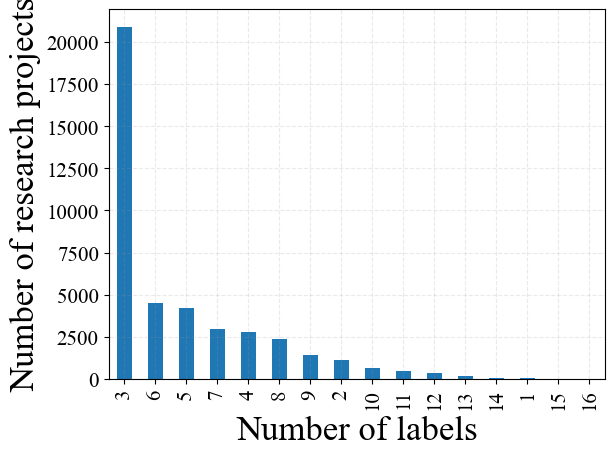

<Figure size 640x480 with 0 Axes>

In [30]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.style.use('default')
plt.rc('font',family='Times New Roman') 
plt.grid(visible=True, which='major', color='#999999', linestyle='--', alpha=0.2)

counts = data['labels'].apply(lambda x: len(x.split('|'))).value_counts()
counts.plot.bar( grid=True)
weighted_stats = DescrStatsW(counts.index, weights=counts, ddof=0)

plt.xlabel('Number of labels', fontsize=25)
plt.ylabel('Number of research projects', fontsize=25)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)


#title='Distribution - number of labels per research project (all classification levels)',
plt.savefig('reports/figures/4_labels_all.pdf', bbox_inches='tight')
print(f'Disregarding the level of classification, one research project contains in average {round(weighted_stats.mean,2)} labels with a standard deviation of $\pm$ {round(weighted_stats.std,2)}.')
 
plt.show()
plt.clf()

16.01% of the research projects do not contain information about the year of funding.


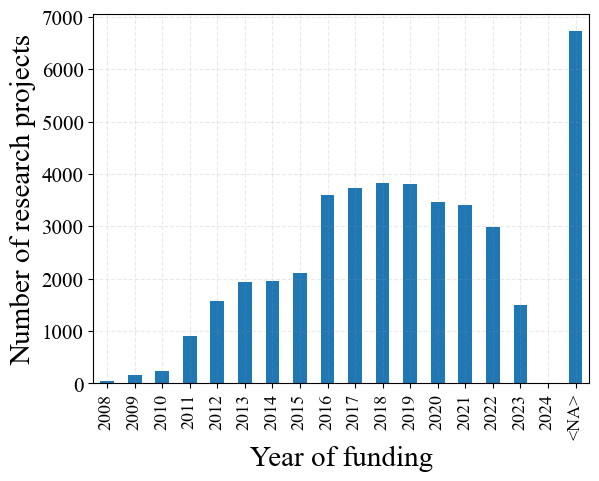

<Figure size 640x480 with 0 Axes>

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.style.use('default')
plt.rc('font',family='Times New Roman') 
plt.grid(visible=True, which='major', color='#999999', linestyle='--', alpha=0.2)

funding_years = data['funding_year'].astype('Int64')
counts = funding_years.value_counts(dropna=False).sort_index()

counts.plot.bar( grid=True)


plt.xlabel('Year of funding', fontsize=21)
plt.ylabel('Number of research projects', fontsize=21)
plt.yticks(fontsize=15)
plt.xticks(fontsize=13)

#title='Distribution of year of funding'

plt.savefig('reports/figures/4_years.pdf' , bbox_inches='tight')
proportion_wo_year = 1- funding_years.dropna().value_counts().sum()/counts.sum()

print(f'{round(proportion_wo_year*100,2)}% of the research projects do not contain information about the year of funding.')  
plt.show()
plt.clf()

In [17]:
all_IDs = pd.DataFrame([x for item in data['label_IDs'] for x in item], columns = ['label_IDs'])
all_IDs.value_counts().sort_values()

label_IDs
20404            4
40503            8
30310            8
30501            9
30104           10
             ...  
203           6480
3             8790
5             9242
1            12751
2            19492
Length: 305, dtype: int64

In [21]:
set1 = set(all_IDs['label_IDs'])
set2 = set(df_classifications.index)
missing = list(sorted(set2 - set1))

print(f'The following labels could not be found in the data set:')
for field in missing:
    print(f'{df_classifications["Label_en"].loc[field]}[{field}]')


The following labels could not be found in the data set:
bioethics[20804]
psychology ( excluding applied psychology )[50101]
law ( excluding law and society )[50501]


In [22]:
word_counts = data[['title_en', 'description_en']].apply(lambda x: len(' '.join(x).split()), axis=1)
# Calculate the mean and standard deviation of the number of words
mean_word_count = np.mean(word_counts)
std_word_count = np.std(word_counts)

print(f'mean: {mean_word_count}, standard deviation: {std_word_count}, min: {np.min(word_counts)}, max{np.max(word_counts)} \n {sum(word_counts<20)} data points contain less than 20 words in the text.')

mean: 233.58639902850203, standard deviation: 85.53594161618757, min: 20, max3810 
 0 data points contain less than 20 words in the text.


In [23]:
data['word_count'] = data[['title_en', 'description_en']].apply(lambda x: len(' '.join(x).split()), axis=1)
# data['title_en'].apply(lambda x: len(x.split())) 
print(sum(data['word_count']>512))
# Sort the DataFrame by the number of words in the 'text' column in ascending order
df = data.sort_values(by='word_count', ascending=False)
df.head(10)

537


,title_sv,title_en,funding_year,labels,research_fields_sv,description_sv,description_en,text,label_IDs,word_count
58712,Harbours - silting and environmental sedimento...,Harbours - silting and environmental sedimento...,NaN,Chemical Sciences | Computer and Information S...,Annan data- och informationsvetenskap | Data- ...,"1.Identification of the sediment sources, tran...","1.Identification of the sediment sources, tran...",Harbours - silting and environmental sedimento...,"[10404, 10299, 104, 105, 10502, 10506, 10504, ...",3810
58838,"Interactions at the molecular level, of biolog...","Interactions at the molecular level, of biolog...",NaN,Basic Medicine | Biochemistry and Molecular Bi...,Annan materialteknik | Biokemi och molekylärbi...,The present project constitutes a further qual...,The present project constitutes a further qual...,"Interactions at the molecular level, of biolog...","[20599, 104, 106, 301, 10602, 10405, 30106, 3,...",3275
59041,CHARACTERISTICS OF RADON- AND THORON DAUGHTERS...,CHARACTERISTICS OF RADON- AND THORON DAUGHTERS...,NaN,Atom and Molecular Physics and Optics | Chemic...,Annan matematik | Atom- och molekylfysik och o...,<br/>A radon chamber was designed to study the...,<br/>A radon chamber was designed to study the...,CHARACTERISTICS OF RADON- AND THORON DAUGHTERS...,"[10404, 101, 10102, 103, 104, 10302, 10199, 1]",2555
58956,Immunotoxicology of drugs and biotechnology-de...,Immunotoxicology of drugs and biotechnology-de...,NaN,Basic Medicine | Clinical Medicine | Genetics ...,Farmaceutiska vetenskaper | Genetik | Hälsovet...,The purpose of this project was to utilise rec...,The purpose of this project was to utilise rec...,Immunotoxicology of drugs and biotechnology-de...,"[302, 10609, 10605, 30101, 301, 30219, 20908, ...",2371
56597,DEVELOPMENT OF A COMPREHENSIVE DECISION SUPPOR...,DEVELOPMENT OF A COMPREHENSIVE DECISION SUPPOR...,NaN,"Astronomy, Astrophysics and Cosmology | Chemic...",Annan data- och informationsvetenskap | Annan ...,Task description <br/><br/>The purpose of the ...,Task description <br/><br/>The purpose of the ...,DEVELOPMENT OF A COMPREHENSIVE DECISION SUPPOR...,"[101, 10299, 103, 104, 10305, 102, 10101, 1019...",2335
58714,Predicting the effects of environmental change...,Predicting the effects of environmental change...,NaN,Behavioural Sciences Biology | Biological Scie...,Annan geovetenskap och miljövetenskap | Biolog...,The chief objectives of this four-year project...,The chief objectives of this four-year project...,Predicting the effects of environmental change...,"[10599, 10614, 10508, 106, 105, 10613, 10608, 1]",2178
58875,Development plasma technology continuous proce...,Development plasma technology continuous proce...,NaN,Biochemistry and Molecular Biology | Biologica...,Annan matematik | Biokemi och molekylärbiologi...,<br/>The analytical and experimental work of t...,<br/>The analytical and experimental work of t...,Development plasma technology continuous proce...,"[10404, 101, 103, 104, 106, 20504, 10602, 1030...",1614
58717,Sized-based tools for managing freshwater fish...,Sized-based tools for managing freshwater fish...,NaN,Behavioural Sciences Biology | Biological Scie...,Annan geovetenskap och miljövetenskap | Annan ...,- To implement a monitoring programme for fish...,- To implement a monitoring programme for fish...,Sized-based tools for managing freshwater fish...,"[10599, 101, 50201, 502, 5, 10509, 106, 105, 1...",1502
58331,"European prospective study of environment, all...","European prospective study of environment, all...",NaN,Clinical Medicine | Health Sciences | Medical ...,Annan klinisk medicin | Hälsovetenskap | Klini...,<br/>1. Objectives and expected achievements <...,<br/>1. Objectives and expected achievements <...,"European prospective study of environment, all...","[302, 30305, 30219, 30304, 30299, 3, 303]",1468
59016,Biotechnology of extremophiles,Biotechnology of extremophiles,NaN,Biochemistry and Molecular Biology | Biologica...,Bioke

# Analysis long tail of label distribution in sample

/var/folders/10/g950pxln7y5c3bn_j_q00lc40000gn/T/ipykernel_9227/1249350119.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label_IDs'] = filtered_df['label_IDs'].astype('int')


Plot of all labels found with a classification level of 1. 6 labels were used out of 6 possible ones.


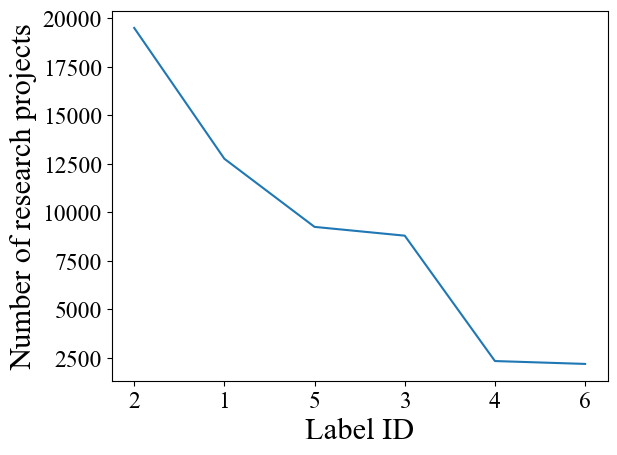

/var/folders/10/g950pxln7y5c3bn_j_q00lc40000gn/T/ipykernel_9227/1249350119.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label_IDs'] = filtered_df['label_IDs'].astype('int')


Plot of all labels found with a classification level of 3. 42 labels were used out of 42 possible ones.


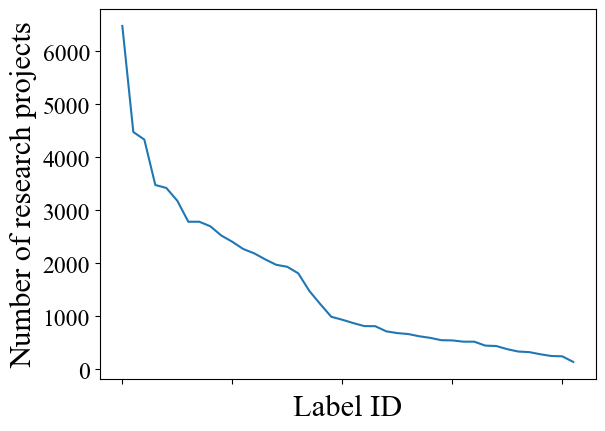

/var/folders/10/g950pxln7y5c3bn_j_q00lc40000gn/T/ipykernel_9227/1249350119.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label_IDs'] = filtered_df['label_IDs'].astype('int')


Plot of all labels found with a classification level of 5. 257 labels were used out of 260 possible ones.


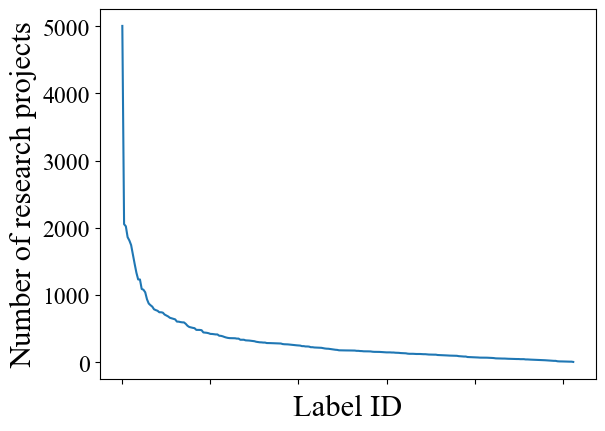

<Figure size 640x480 with 0 Axes>

In [24]:

k = 1
for i, all_label in zip([1,3,5], [6,42,260]):

    fig = plt.figure()
    # Filter the data depending on the level of classification 
    
    filtered_df = all_IDs[all_IDs['label_IDs'].apply(lambda x: True if len(str(x)) == i else False)]
    filtered_df['label_IDs'] = filtered_df['label_IDs'].astype('int')
    
    print(f"Plot of all labels found with a classification level of {i}. {filtered_df.value_counts().size} labels were used out of {all_label} possible ones.")
    
    ax = fig.add_subplot()
    plt.style.use('default')
    plt.rc('font',family='Times New Roman') 
    plt.grid(visible=True, which='major', color='#999999', linestyle='--', alpha=0.2)

  
    counts = filtered_df.value_counts()
    counts.plot() 
    if i == 1:
        x = [i[0] for i in counts.index.values.tolist()]
        xi = list(range(len(x)))
        plt.xticks(xi, x)
    else:
        ax.set_xticklabels([])
    
    plt.xlabel('Label ID', fontsize=22)
    plt.ylabel('Number of research projects', fontsize=22)
    plt.yticks(fontsize=17)
    plt.xticks(fontsize=17)

    plt.savefig(f'reports/figures/labels_level_{i}.pdf', bbox_inches='tight')

    plt.show()
    k +=1
plt.clf()

# Analysis labels for each data point

In [25]:
level_IDs = list()
for value in data['label_IDs']:
    label_level = list()
    for item in value:
        label_level.append(len(str(item)))
    level_IDs.append(label_level)

In [26]:
level_ids = pd.DataFrame()
k = 1
for i, name in zip([1,3,5],['level_1','level_2','level_3']):
    temp_list = list(x.count(i) for x in level_IDs)
    level_ids[name] = temp_list
    print(f" A research project has in average {round(level_ids[name].mean(),2)} labels of level {k} with a standard deviation of {round(level_ids[name].std(),2)}")
    #level_ids[name].value_counts().plot(kind ='bar', title= name)   
    plt.show()
    k +=1

 A research project has in average 1.3 labels of level 1 with a standard deviation of 0.57
 A research project has in average 1.58 labels of level 2 with a standard deviation of 0.87
 A research project has in average 1.92 labels of level 3 with a standard deviation of 1.17


In [27]:
all_IDs = pd.DataFrame([x for item in data['label_IDs'] for x in item], columns = ['label_IDs'])

In [28]:
all_IDs

,label_IDs
0,5
1,50902
2,509
3,6
4,60502
...,...
201586,106
201587,105
201588,10502
201589,10602
